# Aprendizaje Automatico - Diplodatos 2022
Trabajo Práctico MLP 

In [1]:
integrantes = ["Maria Virginia Romero Messein", "Diana Carolina Fonnegra Mora"]
print('Integrantes: \n ',*integrantes, sep="\n")

Integrantes: 
 
Maria Virginia Romero Messein
Diana Carolina Fonnegra Mora


# Notebook 1 Basic MLP.
En este práctico trabajaremos en el problema de clasificación de texto del MeLi Challenge 2019

El datasets tiene información acerca de títulos de publicaciones, categoría de los mismos, información de idioma y confiabilidad de la anotación. Cuenta con anotaciones de títulos para 632 categorías distintas.

El dataset también cuenta con una partición de test que está compuesta de 63680 de ejemplos con las mismas categorías (aunque no necesariamente la misma distribución).

El ejercicio consiste en Implementar una red neuronal simple (MLP. Perceptrón Multicapa) que asigne una categoría dado un título.

Algunas consideraciones a tener en cuenta para estructurar el trabajo:

A) Hacer un preprocesamiento de los datos (¿Cómo vamos a representar los datos de entrada y las categorías?).

B) Tener un manejador del dataset (alguna clase o función que nos divida los datos en batches).

C) Crear una clase para el modelo que se pueda instanciar con diferentes hiperparámetros

D) Hacer logs de entrenamiento (reportar tiempo transcurrido, iteraciones/s, loss, accuracy, etc.). Usar MLFlow.

E) Hacer un gráfico de la función de loss a lo largo de las epochs. MLFlow también puede generar la gráfica.

F) Reportar performance en el conjunto de test con el mejor modelo entrenado. La métrica para reportar será balanced accuracy.


# Resultados del práctico 1:
Para la resolución de las tareas propuestas realizamos los siguientes pasos. Primero definimos las librerías necesarias:

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, IterableDataset

from gensim import corpora
from gensim.parsing import preprocessing
from gensim.models import KeyedVectors
from gensim.parsing import preprocessing

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

import tqdm
from tqdm.notebook import tqdm, trange
from gensim.models import KeyedVectors

import csv
import functools
import gzip
import numpy as np
import pandas as pd
import tempfile
import json
import mlflow

In [3]:
# confirmamos la version de pytorch:
torch.__version__

'1.10.1+cu111'

Para la descarga de la información usamos:

In [4]:
# #Los datos fueron cargados la primera vez que se ejecutó este bloque de código, por este motivo el código está comentado
# !mkdir ./data
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
# !tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/
# !pip install mlflow


In [5]:
# !wget https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2

In [6]:
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/SBW-vectors-300-min5.txt.bz2 -o ./data/SBW-vectors-300-min5.txt.bz2
# !tar -xf ./data/SBW-vectors-300-min5.txt.bz2 -C ./data/

Leemos el conjunto de datos fragmentado:

In [7]:
# Definimos el conjunto de datos de entrenamiento / Formato Json a Dataframe:
train_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz',\
                                              lines=True, chunksize=100000)], ignore_index=True)
train_df.head(3)

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280


In [8]:
train_df

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280
...,...,...,...,...,...,...,...,...,...,...
4895275,spanish,unreliable,Kit 2 Bieletas Delanteras Monroe Vw Fox 1.6 - ...,SWAY_BAR_LINKS,train,"[kit, bieletas, delanteras, monroe, fox]","[521, 4798, 9027, 3896, 593]",28,632,4895280
4895276,spanish,unreliable,Organo Teclado Casio Ct-x5000 61 Teclas Profes...,MUSICAL_KEYBOARDS,train,"[organo, teclado, casio, teclas, profesional, ...","[104, 30, 101, 6035, 962, 769]",24,632,4895280
4895277,spanish,reliable,Mochila Impermeable Belvento Fausto,BACKPACKS,train,"[mochila, impermeable, belvento, fausto]","[337, 2560, 1, 4711]",74,632,4895280
4895278,spanish,unreliable,Mochila San Lorenzo De Espalda 16p Sl001,BACKPACKS,train,"[mochila, san, lorenzo, espalda]","[337, 2125, 4974, 335]",74,632,4895280


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895280 entries, 0 to 4895279
Data columns (total 10 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   language         object
 1   label_quality    object
 2   title            object
 3   category         object
 4   split            object
 5   tokenized_title  object
 6   data             object
 7   target           int64 
 8   n_labels         int64 
 9   size             int64 
dtypes: int64(3), object(7)
memory usage: 373.5+ MB


In [10]:
# Definimos el conjunto de datos de test / Formato Json a Dataframe:
valid_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz',\
                                              lines=True, chunksize=100000)], ignore_index=True)
valid_df.tail(3)
# train_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz',\
#                                               lines=True, chunksize=100000)], ignore_index=True)
# pd.read_json("/content/data/meli-challenge-2019/spanish.validation.jsonl.gz",lines=True, orient='records')

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
1223817,spanish,unreliable,Kit Portero Eléctrico P/5 Dptos Commax,ELECTRONIC_ENTRANCE_INTERCOMS,validation,"[kit, portero, eléctrico, dptos, commax]","[521, 552, 495, 45123, 549]",114,632,1223820
1223818,spanish,reliable,Pedigree Cachorros 21kg Envío Gratis San Isidr...,CATS_AND_DOGS_FOODS,validation,"[pedigree, cachorros, envío, gratis, san, isid...","[4683, 3490, 1465, 1429, 2125, 11856, 11857]",178,632,1223820
1223819,spanish,unreliable,Instrumental Quirúrgico - Pinza Gemini 28 Cm,DENTAL_PLIERS,validation,"[instrumental, quirúrgico, pinza, gemini]","[3886, 3206, 1514, 11349]",500,632,1223820


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895280 entries, 0 to 4895279
Data columns (total 10 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   language         object
 1   label_quality    object
 2   title            object
 3   category         object
 4   split            object
 5   tokenized_title  object
 6   data             object
 7   target           int64 
 8   n_labels         int64 
 9   size             int64 
dtypes: int64(3), object(7)
memory usage: 373.5+ MB


In [12]:
# Definimos el conjunto de datos de test / Formato Json a Dataframe:
test_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.test.jsonl.gz',\
                                             lines=True, chunksize=100000)], ignore_index=True)
test_df.tail(3)

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
63677,spanish,reliable,Gimnasio Bebe Manta Didactica Tiny Love Kick A...,BABY_GYMS,test,"[gimnasio, bebe, manta, didactica, tiny, love,...","[1305, 915, 2620, 9537, 1308, 49, 6872, 1512, ...",258,632,63680
63678,spanish,reliable,Gimnasio Manta Alfombra Didactica Fitchbaby Ju...,BABY_GYMS,test,"[gimnasio, manta, alfombra, didactica, fitchba...","[1305, 2620, 794, 9537, 1, 282, 9424]",258,632,63680
63679,spanish,reliable,Gimnasio P/ Bebé Alfombra Zoo Animales Didácti...,BABY_GYMS,test,"[gimnasio, bebé, alfombra, zoo, animales, didá...","[1305, 659, 794, 20048, 1091, 14707, 4716]",258,632,63680


In [13]:
# creando dos subdataset y dando información general: 
df_train = train_df.loc[:, ['category', 'title']]
print(f'Forma del conjunto de datos entrenamiento: {df_train.shape}, \n{df_train.head(3)}\n')
df_train.info()

Forma del conjunto de datos entrenamiento: (4895280, 2), 
          category                                 title
0       DOLLHOUSES       Casita Muñecas Barbies Pintadas
1    TOILETRY_BAGS          Neceser Cromado Holográfico 
2  CAR_SEAT_COVERS  Funda Asiento A Medida D20 Chevrolet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895280 entries, 0 to 4895279
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   category  object
 1   title     object
dtypes: object(2)
memory usage: 74.7+ MB


In [14]:
# Ahora con datos de prueba:
df_test = test_df.loc[:, ['category', 'title']]
print(f'Forma del conjunto de datos prueba: {df_test.shape}, \n{df_test.head(3)}\n')
df_test.info()

Forma del conjunto de datos prueba: (63680, 2), 
      category                                              title
0  DIAPER_BAGS  Mochilas Maternales Bolsos Bebe Simil Cuero Ma...
1  DIAPER_BAGS  Bolso Maternal/bebe Incluye Cambiador + Correa...
2  DIAPER_BAGS    Mochila Maternal Land  + Gancho Envio Gratis-cc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63680 entries, 0 to 63679
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  63680 non-null  object
 1   title     63680 non-null  object
dtypes: object(2)
memory usage: 995.1+ KB


In [15]:
df_test

,category,title
0,DIAPER_BAGS,Mochilas Maternales Bolsos Bebe Simil Cuero Ma...
1,DIAPER_BAGS,Bolso Maternal/bebe Incluye Cambiador + Correa...
2,DIAPER_BAGS,Mochila Maternal Land + Gancho Envio Gratis-cc
3,DIAPER_BAGS,Bolso Maternal Moderno Con Cambiador Y Correa ...
4,DIAPER_BAGS,Bolso Maternal Moderno Con Cambiador Y Correa ...
...,...,...
63675,BABY_GYMS,Gimnasio Gym Manta Bebe Tiny Love Musica Luz M...
63676,BABY_GYMS,Gimnasio Manta Con Actividades Para Bebe 846 Ath
63677,BABY_GYMS,Gimnasio Bebe Manta Didactica Tiny Love Kick A...
63678,BABY_GYMS,Gimnasio Manta Alfombra Didactica Fitchbaby Ju...


In [16]:
# creando dos subdataset y dando información general: 
val_df = valid_df.loc[:, ['category', 'title']]
print(f'Forma del conjunto de datos Validacion: {val_df.shape}, \n{val_df.head(3)}\n')
val_df.info()

Forma del conjunto de datos Validacion: (1223820, 2), 
                      category  \
0              ENGINE_BEARINGS   
1  ELECTRIC_DEMOLITION_HAMMERS   
2                 FISHING_RODS   

                                               title  
0                           Metal Biela Dw10 Hdi 2.0  
1  Repuestos Martillo Rotoprcutor Bosch Gshsce Po...  
2  Pesca Caña Pejerrey Colony Brava 3m Fibra De V...  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223820 entries, 0 to 1223819
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   category  1223820 non-null  object
 1   title     1223820 non-null  object
dtypes: object(2)
memory usage: 18.7+ MB


In [17]:
val_df.head()

,category,title
0,ENGINE_BEARINGS,Metal Biela Dw10 Hdi 2.0
1,ELECTRIC_DEMOLITION_HAMMERS,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...
2,FISHING_RODS,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...
3,PORCELAIN_TILES,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...
4,HAIR_SHAMPOOS_AND_CONDITIONERS,Reconstruction Semi Di Lino Alfaparf Shampoo 1...


Definimos las clases que seran útiles para el procesamiento del conjunto de datos:

In [18]:
data = pd.concat([df_train,val_df,df_test], ignore_index=True)
data.head(3)

,category,title
0,DOLLHOUSES,Casita Muñecas Barbies Pintadas
1,TOILETRY_BAGS,Neceser Cromado Holográfico
2,CAR_SEAT_COVERS,Funda Asiento A Medida D20 Chevrolet


In [19]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
 #       self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        #### Cambio
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        self.dictionary.compactify()

        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1 
        })
        #### Cambio
        
        
        
        

        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [20]:
class MelichanllegeDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item
    
    

Pasamos a aplicar las clases definidas previamente para preprocesar ambos conjuntos:

In [21]:
preprocess_train = RawDataProcessor(df_train)
train_ds = MelichanllegeDataset(df_train, transform=preprocess_train)
train_ds

In [22]:
preprocess_train = RawDataProcessor(df_train)
train_ds = MelichanllegeDataset(df_train, transform=preprocess_train)

preprocess_test = RawDataProcessor(df_test)
test_ds = MelichanllegeDataset(df_test, transform=preprocess_test)

preprocess_valid = RawDataProcessor(val_df)
dev_ds = MelichanllegeDataset(val_df, transform=preprocess_test)


print(f"Datasets loaded with {len(train_ds)} training elements and {len(test_ds)} test elements")
print(f"Sample train element:\n{train_ds[0]}")

Datasets loaded with 4895280 training elements and 63680 test elements
Sample train element:
{'data': [50001, 2, 50000, 3], 'target': 188}


Definimos el modulo Padsequences, recordando que este se define para tomar un valor mínimo y opcionalmente un valor máximo, así como un valor de relleno (pad) y una lista de secuencias. Este nos retornara un tensor con padding sobre dichas secuencias.

In [23]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

## DataLoaders
Aplicamos el modulo anterior y especificamos nuestros DataLoaders (uno para entrenamiento y otro para evaluación).

In [24]:
pad_sequences = PadSequences()

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers=0)

dev_loader = DataLoader(dev_ds, batch_size=128, shuffle=True,
                         collate_fn=pad_sequences, drop_last=False, num_workers=0)


In [25]:
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers=0)

## Parte 2: Esqueleto de la red MLP
Definimos el modelo a entrenar.

In [26]:
# Eligiendo dispositivo (se puede cambiar en notebook settings)
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda:0")
    print("GPU disponible")
else:
    device = torch.device("cpu")
    print("GPU no disponible, usando CPU")

GPU disponible


In [27]:
import bz2
import os
import sys 

In [28]:
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score

## Experimento de MLflow

### Primer caso MLP 1:

In [29]:
class MLP(nn.Module):
    
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden_layer1 = nn.Linear(vector_size, 256)
        self.hidden_layer2 = nn.Linear(256, 300)
        self.hidden_layer3 = nn.Linear(300, 256)
        self.output_layer = nn.Linear(256, 632)
        self.vector_size = vector_size
     
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(x)       
        x = self.hidden_layer1(x)  
        x = F.relu(self.hidden_layer2(x)) 
        x = self.hidden_layer3(x)
        x = F.relu(x)
        x = self.output_layer(x)

        return x
    
    

Encapsularemos el algoritmo de entrenamiento dentro de una función parametrizable. La función debería devolver los resultados obtenidos.

In [30]:
# Some default values
EPOCHS = 6

mlflow.set_experiment("Experimento_MLP_1")

with mlflow.start_run():
    
    mlflow.log_param("model_name", "MLP")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": 256,
        "hidden2_size": 300,
        "hidden3_size": 256,
    })
    model = MLP("./data/SBW-vectors-300-min5.txt.bz2",preprocess_train.dictionary, 300, True)
    model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    #pad_sequeces = PadSequences(max_length=max_sequence_len) # ojo
    
    history1 = {'val_loss': [],
               'train_loss': [],
               'total_accuracy': []
              }    
    
    for epoch in range(EPOCHS):  
        running_loss_train = []
        
        model.train()
        
        pbar = tqdm(train_loader)
        
        for i, data in enumerate(pbar, 1):
                       
            optimizer.zero_grad()
            
            inputs = data["data"].to(device)
            labels = data["target"].squeeze().long()
            labels = labels.to(device)       
            
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train.append(loss.item())
        
        longitud_vec = len(running_loss_train)
        sumatoria_vec = sum(running_loss_train)
            
        mlflow.log_metric("train_loss", sumatoria_vec/longitud_vec, epoch)
        history1['train_loss'].append((sumatoria_vec/longitud_vec, epoch))
        
        # Controlamos las metricas dentro de las epocas
        print(f'Epoca: {epoch}')
        print(f'\nPerdida-loss: {sumatoria_vec/longitud_vec}')
        
        #listas a rellenar con los valores obtenidos en las iteraciones
        running_loss_dev = []
        targets = []
        predictions = []
        
        # Modelo
        
        model.eval()

        
        for i, data in enumerate(tqdm(dev_loader)):
            inputs_v = data["data"].to(device)
            labels_v = data["target"].squeeze().long()
            labels_v = labels_v.to(device)
            
            output = model(inputs_v)
            running_loss_dev.append(loss_function(output, labels_v).item())
            
            _, predicted = torch.max(output.data, 1)
            
            targets.extend(labels_v.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
        
        
        # Controlamos ahora las metricas para el conjunto de validacion    
        mlflow.log_metric("val_loss", sum(running_loss_dev) / len(running_loss_dev), epoch)
        mlflow.log_metric("val_avp", balanced_accuracy_score(targets, predictions), epoch)
        
        
        history1['val_loss'].append((sum(running_loss_dev) / len(running_loss_dev), epoch))
        history1['total_accuracy'].append((balanced_accuracy_score(targets, predictions), epoch))
       
        print(f'Perdida-loss/validacion: {sum(running_loss_dev)/len(running_loss_dev)}')
        print(f'val_avp: {balanced_accuracy_score(targets, predictions)}')

                

  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 0

Perdida-loss: 2.9069283271306543


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 9.781678325734461
val_avp: 0.0020350165994680435


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 1

Perdida-loss: 2.0181324370313525


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.189337384922688
val_avp: 0.0024493035640493718


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 2

Perdida-loss: 1.8417544991880606


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.306747626420519
val_avp: 0.0021648197401102545


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 3

Perdida-loss: 1.760427758447141


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.26819789192712
val_avp: 0.0018721368701719366


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 4

Perdida-loss: 1.7134397579495588


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.352384521083039
val_avp: 0.0019142289373750355


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 5

Perdida-loss: 1.6822640083150655


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.298405699140481
val_avp: 0.00199676755452454


In [31]:
print(model)


MLP(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (hidden_layer1): Linear(in_features=300, out_features=256, bias=True)
  (hidden_layer2): Linear(in_features=256, out_features=300, bias=True)
  (hidden_layer3): Linear(in_features=300, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=632, bias=True)
)


In [32]:
history1

{'val_loss': [(9.781678325734461, 0),
  (10.189337384922688, 1),
  (10.306747626420519, 2),
  (10.26819789192712, 3),
  (10.352384521083039, 4),
  (10.298405699140481, 5)],
 'train_loss': [(2.9069283271306543, 0),
  (2.0181324370313525, 1),
  (1.8417544991880606, 2),
  (1.760427758447141, 3),
  (1.7134397579495588, 4),
  (1.6822640083150655, 5)],
 'total_accuracy': [(0.0020350165994680435, 0),
  (0.0024493035640493718, 1),
  (0.0021648197401102545, 2),
  (0.0018721368701719366, 3),
  (0.0019142289373750355, 4),
  (0.00199676755452454, 5)]}

### Segundo caso MLP2:

In [33]:
class MLP2(nn.Module):
    
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden_layer1 = nn.Linear(vector_size, 600)
        self.hidden_layer2 = nn.Linear(600, 450)
        self.hidden_layer3 = nn.Linear(450, 300)
        self.hidden_layer4 = nn.Linear(300, 500)
        self.output_layer = nn.Linear(500, 632)
        self.vector_size = vector_size
     
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.gelu(x) 
        x = self.hidden_layer1(x) 
        x = F.gelu(self.hidden_layer2(x))  
        x = self.hidden_layer3(x)
        x = F.relu(x)
        x = F.relu(self.hidden_layer4(x)) 
        x = self.output_layer(x)

        return x
    

In [34]:
# Some default values
EPOCHS = 6

mlflow.set_experiment("Experimento_2_MLP2")

with mlflow.start_run():
    
    mlflow.log_param("model_name", "MLP2")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": 600,
        "hidden2_size": 450,
        "hidden3_size": 300,
        "hidden4_size": 500,
        
    })
    model_c2 = MLP2("./data/SBW-vectors-300-min5.txt.bz2",preprocess_train.dictionary, 300, True)
    model_c2.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_c2.parameters(), lr=1e-3, weight_decay=1e-5)
    
    #pad_sequeces = PadSequences(max_length=max_sequence_len) # ojo
    history = {'val_loss': [],
               'train_loss': [],
               'total_accuracy': []
              }
    
    for epoch in range(EPOCHS):  
        
        model_c2.train()
        running_loss_train = []
        pbar = tqdm(train_loader)
        
        for i, data in enumerate(pbar, 1):
                       
            optimizer.zero_grad()
            
            inputs = data["data"].to(device)
            labels = data["target"].squeeze().long()
            labels = labels.to(device)       
            
            outputs = model_c2(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train.append(loss.item())
        
        
        longitud_vec = len(running_loss_train)
        sumatoria_vec = sum(running_loss_train)  
        
        mlflow.log_metric("train_loss", sumatoria_vec/longitud_vec, epoch)
        history['train_loss'].append((sumatoria_vec/longitud_vec, epoch))

        
        # Controlamos las metricas dentro de las epocas
        print(f'Epoca: {epoch}')
        print(f'\nPerdida-loss: {sumatoria_vec/longitud_vec}')

        model_c2.eval()            

        
        #listas a rellenar con los valores obtenidos en las iteraciones
        running_loss_dev = []
        targets = []
        predictions = []
        
        for i, data in enumerate(tqdm(dev_loader)):
            inputs_v = data["data"].to(device)
            labels_v = data["target"].squeeze().long()
            labels_v = labels_v.to(device)
            
            output = model_c2(inputs_v)
            running_loss_dev.append(loss_function(output, labels_v).item())
            
            _, predicted = torch.max(output.data, 1)
            
            targets.extend(labels_v.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            
        
        # Controlamos ahora las metricas para el conjunto de validacion    
        mlflow.log_metric("val_loss", sum(running_loss_dev) / len(running_loss_dev), epoch)
        mlflow.log_metric("val_avp", balanced_accuracy_score(targets, predictions), epoch)
        
        
        history['val_loss'].append((sum(running_loss_dev) / len(running_loss_dev), epoch))
        history['total_accuracy'].append((balanced_accuracy_score(targets, predictions), epoch))
       
        print(f'Perdida-loss/validacion: {sum(running_loss_dev)/len(running_loss_dev)}')
        print(f'val_avp: {balanced_accuracy_score(targets, predictions)}')

        

  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 0

Perdida-loss: 2.492640104725838


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.33177529486421
val_avp: 0.0022108546354928627


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 1

Perdida-loss: 1.7021600783237492


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.249868359931765
val_avp: 0.002104147063025205


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 2

Perdida-loss: 1.5663068934365307


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.425987332317526
val_avp: 0.0015398429215359069


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 3

Perdida-loss: 1.4952440010814017


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.693938938799924
val_avp: 0.0016285295371558425


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 4

Perdida-loss: 1.4487769038556588


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.78709707936341
val_avp: 0.0016289091778191734


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoca: 5

Perdida-loss: 1.412895475459077


  0%|          | 0/9562 [00:00<?, ?it/s]

Perdida-loss/validacion: 10.571424018087509
val_avp: 0.0019504728248230967


In [35]:
print(model_c2)

MLP2(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (hidden_layer1): Linear(in_features=300, out_features=600, bias=True)
  (hidden_layer2): Linear(in_features=600, out_features=450, bias=True)
  (hidden_layer3): Linear(in_features=450, out_features=300, bias=True)
  (hidden_layer4): Linear(in_features=300, out_features=500, bias=True)
  (output_layer): Linear(in_features=500, out_features=632, bias=True)
)


In [36]:
history

{'val_loss': [(10.33177529486421, 0),
  (10.249868359931765, 1),
  (10.425987332317526, 2),
  (10.693938938799924, 3),
  (10.78709707936341, 4),
  (10.571424018087509, 5)],
 'train_loss': [(2.492640104725838, 0),
  (1.7021600783237492, 1),
  (1.5663068934365307, 2),
  (1.4952440010814017, 3),
  (1.4487769038556588, 4),
  (1.412895475459077, 5)],
 'total_accuracy': [(0.0022108546354928627, 0),
  (0.002104147063025205, 1),
  (0.0015398429215359069, 2),
  (0.0016285295371558425, 3),
  (0.0016289091778191734, 4),
  (0.0019504728248230967, 5)]}

In [37]:
mlflow.search_runs()
runs = mlflow.search_runs()
runs[runs.status == "FINISHED"]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.val_loss,metrics.val_avp,params.freeze_embedding,params.embedding_size,params.hidden3_size,params.hidden2_size,params.model_name,params.hidden4_size,params.hidden1_size,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user
0,91d31f260dbf440593e48d8fd6109d60,5,FINISHED,file:///users/dfonnegra/mlruns/5/91d31f260dbf4...,2022-11-02 11:17:15.217000+00:00,2022-11-02 12:16:40.525000+00:00,1.412895,10.571424,0.00195,True,300,300,450,MLP2,500,600,skittish-skink-437,LOCAL,/users/dfonnegra/miniconda3/envs/deeplearning/...,dfonnegra


# Resultados de las métricas

### Gráficos para  MLP2

In [87]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.25)


In [82]:
data = []
for epoch, (train_loss, val_loss) in enumerate(zip(
        history1['train_loss'], history['val_loss'])):
#     print((epoch, 'Entrenamiento', train_loss[0]))
#     print((epoch, 'Validación', val_loss[0]))
    data.append((epoch, 'Entrenamiento', train_loss[0]))
    data.append((epoch, 'Validación', val_loss[0]))
data = pd.DataFrame(data=data, columns=['Epoch', 'Conjunto', 'Loss'])


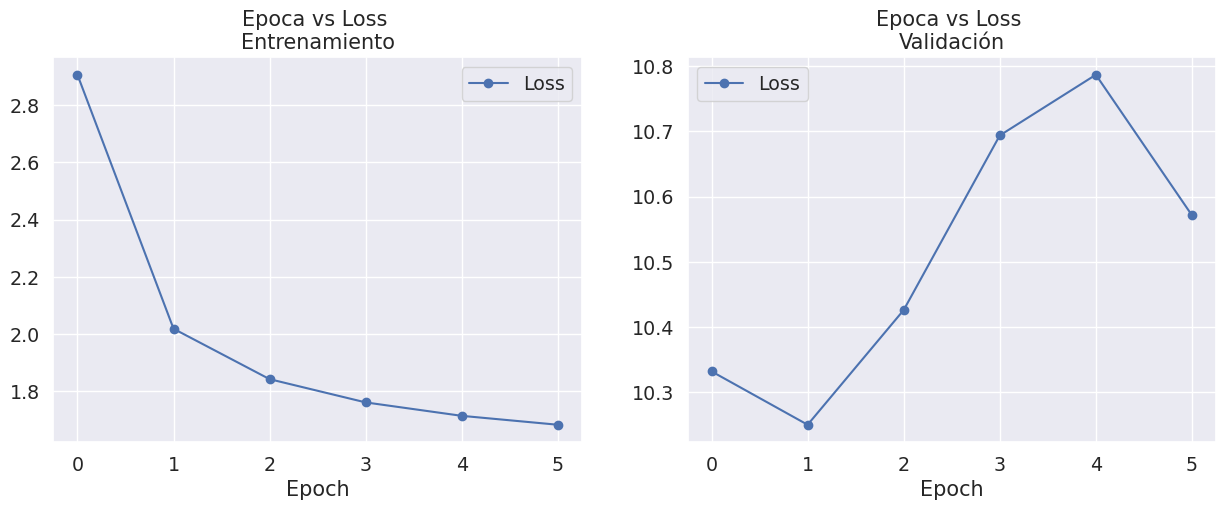

In [89]:
f, ax = plt.subplots(1,2, figsize=(15,5))

data.loc[data.Conjunto=='Entrenamiento', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[0],
                                     kind='line',marker='o',title='Epoca vs Loss \nEntrenamiento')
data.loc[data.Conjunto=='Validación', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[1],
                                                        kind='line',marker='o',title='Epoca vs Loss \nValidación')
plt.show()

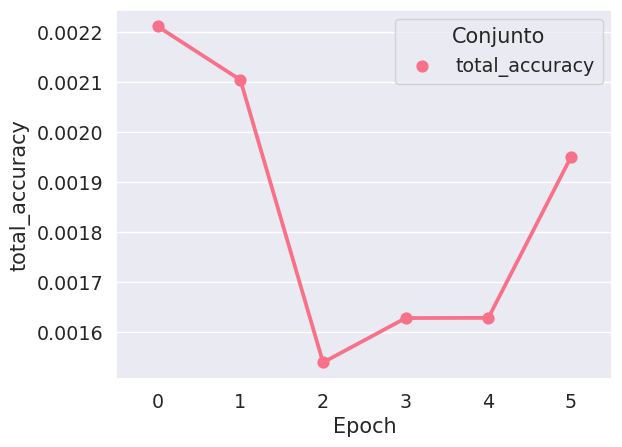

In [102]:
data = []
for total_accuracy,epoch in history['total_accuracy']:
    data.append((epoch,'total_accuracy',total_accuracy))
data = pd.DataFrame(data=data, columns=['Epoch', 'Conjunto', 'total_accuracy'])
sns.pointplot(
    data=data, x='Epoch', y='total_accuracy', hue='Conjunto', palette='husl')
plt.show()

### Gráficos para  MLP2

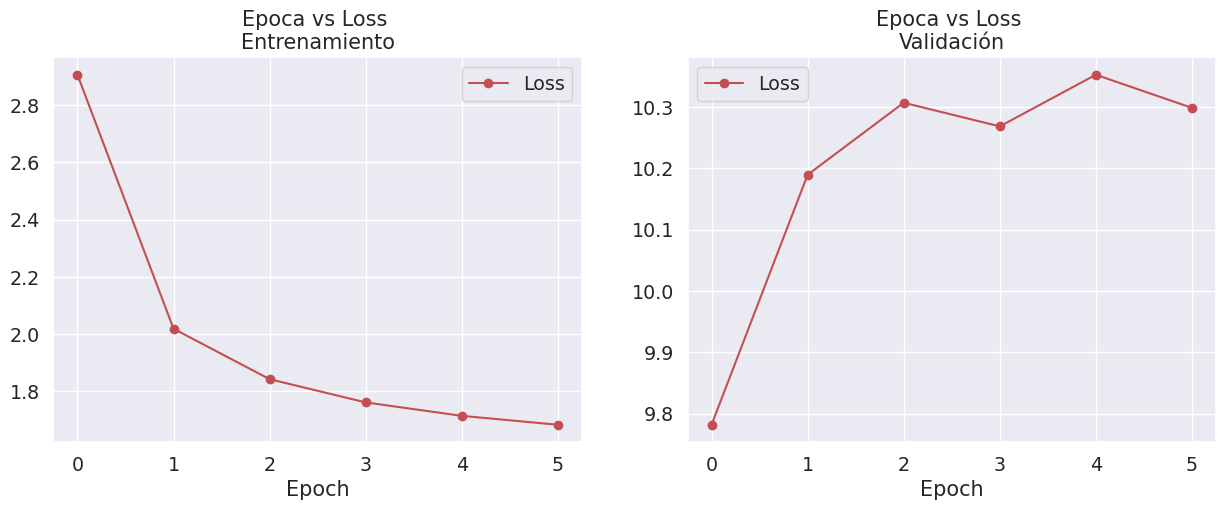

In [110]:
data2 = []
for epoch, (train_loss, val_loss) in enumerate(zip(
        history1['train_loss'], history1['val_loss'])):
#     print((epoch, 'Entrenamiento', train_loss[0]))
#     print((epoch, 'Validación', val_loss[0]))
    data2.append((epoch, 'Entrenamiento', train_loss[0]))
    data2.append((epoch, 'Validación', val_loss[0]))
data2 = pd.DataFrame(data=data2, columns=['Epoch', 'Conjunto', 'Loss'])

f, ax = plt.subplots(1,2, figsize=(15,5))
data2.loc[data2.Conjunto=='Entrenamiento', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[0],
                                    color='r',kind='line',marker='o',title='Epoca vs Loss \nEntrenamiento')
data2.loc[data2.Conjunto=='Validación', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[1],
                                    color='r',kind='line',marker='o',title='Epoca vs Loss \nValidación')
plt.show()

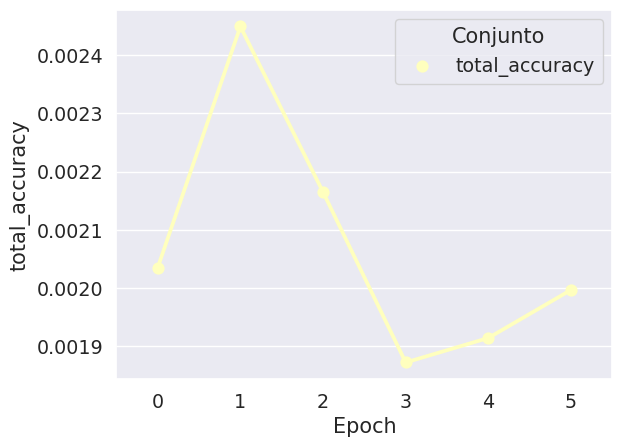

In [109]:
data2 = []
for total_accuracy,epoch in history1['total_accuracy']:
    data2.append((epoch,'total_accuracy',total_accuracy))
data2 = pd.DataFrame(data=data2, columns=['Epoch', 'Conjunto', 'total_accuracy'])
seaborn.pointplot(
    data=data2, x='Epoch', y='total_accuracy', hue='Conjunto', palette='Spectral'
)
plt.show()